In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import multivariate_normal
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import trange
import time
from sklearn import metrics
import abc
import logging
import random
from torch.autograd import Variable

class Algorithm(metaclass=abc.ABCMeta):
    def __init__(self, module_name, name, seed, details=False):
        self.logger = logging.getLogger(module_name)
        self.name = name
        self.seed = seed
        self.details = details
        self.prediction_details = {}

        if self.seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def __str__(self):
        return self.name

    @abc.abstractmethod
    def fit(self, X):
        """
        Train the algorithm on the given dataset
        """

    @abc.abstractmethod
    def predict(self, X):
        """
        :return anomaly score
        """


class PyTorchUtils(metaclass=abc.ABCMeta):
    def __init__(self, seed, gpu):
        self.gpu = gpu
        self.seed = seed
        if self.seed is not None:
            torch.manual_seed(self.seed)
            torch.cuda.manual_seed(self.seed)
        self.framework = 0

    @property
    def device(self):
        return torch.device(f'cuda:{self.gpu}' if torch.cuda.is_available() and self.gpu is not None else 'cpu')

    def to_var(self, t, **kwargs):
        # ToDo: check whether cuda Variable.
        t = t.to(self.device)
        return Variable(t, **kwargs)

    def to_device(self, model):
        model.to(self.device)

class LSTMED(Algorithm, PyTorchUtils):
    def __init__(self, name: str = 'LSTM-ED', num_epochs: int = 10, batch_size: int = 32, lr: float = 1e-3,
                 hidden_size: int = 5, sequence_length: int = 30, train_gaussian_percentage: float = 0.25,
                 n_layers: tuple = (1, 1), use_bias: tuple = (True, True), dropout: tuple = (0, 0),
                 seed: int = None, gpu: int = 0, details=True):
        Algorithm.__init__(self, __name__, name, seed, details=details)
        PyTorchUtils.__init__(self, seed, gpu)
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr

        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.train_gaussian_percentage = train_gaussian_percentage

        self.n_layers = n_layers
        self.use_bias = use_bias
        self.dropout = dropout

        self.lstmed = None
        self.mean, self.cov = None, None

    def fit(self, X):
        data =  X.copy()#X.values
        sequences = [data[i:i + self.sequence_length] for i in range(0,data.shape[0] - self.sequence_length + 1, self.sequence_length)]
        print(len(sequences))
        indices = np.random.permutation(len(sequences))
        split_point = int(self.train_gaussian_percentage * len(sequences))
        train_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                  sampler=SubsetRandomSampler(indices[:-split_point]), pin_memory=True)
        train_gaussian_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                           sampler=SubsetRandomSampler(indices[-split_point:]), pin_memory=True)

        self.lstmed = LSTMEDModule(X.shape[1], self.hidden_size,
                                   self.n_layers, self.use_bias, self.dropout,
                                   seed=self.seed, gpu=self.gpu)
        self.to_device(self.lstmed)
        optimizer = torch.optim.Adam(self.lstmed.parameters(), lr=self.lr)

        self.lstmed.train()
        #loss_list=[]
        for epoch in trange(self.num_epochs):
            #st=time.time()
            logging.debug(f'Epoch {epoch+1}/{self.num_epochs}.')
            for ts_batch in train_loader:
                output = self.lstmed(self.to_var(ts_batch))
                loss = nn.MSELoss(size_average=False)(output, self.to_var(ts_batch.float()))
                #print('error',(loss.float()).mean())
                #loss_list.append(loss)
                self.lstmed.zero_grad()
                loss.backward()
                optimizer.step()
            #print(epoch,'loss: ',np.mean(loss),'time',time.time()-st)

        self.lstmed.eval()
        error_vectors = []
        for ts_batch in train_gaussian_loader:
            output = self.lstmed(self.to_var(ts_batch))
            error = nn.L1Loss(reduce=False)(output, self.to_var(ts_batch.float()))
            error_vectors += list(error.view(-1, X.shape[1]).data.cpu().numpy())

        self.mean = np.mean(error_vectors, axis=0)
        self.cov = np.cov(error_vectors, rowvar=False)

    def predict(self, X):#X: pd.DataFrame):
        data = X.copy() #data = X.values
        sequences = [data[i:i + self.sequence_length] for i in range(0,data.shape[0] - self.sequence_length + 1, self.sequence_length)]
        data_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, shuffle=False, drop_last=False)

        self.lstmed.eval()
        mvnormal = multivariate_normal(self.mean, self.cov, allow_singular=True)
        scores = []
        outputs = []
        errors = []
        for idx, ts in enumerate(data_loader):
            output = self.lstmed(self.to_var(ts))
            error = nn.L1Loss(reduce=False)(output, self.to_var(ts.float()))
            score = -mvnormal.logpdf(error.view(-1, X.shape[1]).data.cpu().numpy())
            #print(idx,'error',(error.float()).mean(),'score',np.mean(score))
            scores.append(score.reshape(ts.size(0), self.sequence_length))
            if self.details:
                outputs.append(output.data.cpu().numpy())
                errors.append(error.data.cpu().numpy())

        # stores seq_len-many scores per timestamp and averages them
        scores = np.concatenate(scores)
        print('scores.shape',scores.shape,np.sum(np.isnan(scores)))#(5760, 90)

        if self.details:
            outputs = np.concatenate(outputs)
            print(outputs.shape)#(5760, 90, 14)
            self.prediction_details.update({'reconstructions_mean': outputs})

            errors = np.concatenate(errors)
            self.prediction_details.update({'errors_mean': errors})

        return scores,outputs


class LSTMEDModule(nn.Module, PyTorchUtils):
    def __init__(self, n_features: int, hidden_size: int,
                 n_layers: tuple, use_bias: tuple, dropout: tuple,
                 seed: int, gpu: int):
        super().__init__()
        PyTorchUtils.__init__(self, seed, gpu)
        self.n_features = n_features
        self.hidden_size = hidden_size

        self.n_layers = n_layers
        self.use_bias = use_bias
        self.dropout = dropout

        self.encoder = nn.LSTM(self.n_features, self.hidden_size, batch_first=True,
                               num_layers=self.n_layers[0], bias=self.use_bias[0], dropout=self.dropout[0])
        self.to_device(self.encoder)
        self.decoder = nn.LSTM(self.n_features, self.hidden_size, batch_first=True,
                               num_layers=self.n_layers[1], bias=self.use_bias[1], dropout=self.dropout[1])
        self.to_device(self.decoder)
        self.hidden2output = nn.Linear(self.hidden_size, self.n_features)
        self.to_device(self.hidden2output)

    def _init_hidden(self, batch_size):
        return (self.to_var(torch.Tensor(self.n_layers[0], batch_size, self.hidden_size).zero_()),
                self.to_var(torch.Tensor(self.n_layers[0], batch_size, self.hidden_size).zero_()))

    def forward(self, ts_batch, return_latent: bool = False):
        batch_size = ts_batch.shape[0]

        # 1. Encode the timeseries to make use of the last hidden state.
        enc_hidden = self._init_hidden(batch_size)  # initialization with zero
        _, enc_hidden = self.encoder(ts_batch.float(), enc_hidden)  # .float() here or .double() for the model

        # 2. Use hidden state as initialization for our Decoder-LSTM
        dec_hidden = enc_hidden

        # 3. Also, use this hidden state to get the first output aka the last point of the reconstructed timeseries
        # 4. Reconstruct timeseries backwards
        #    * Use true data for training decoder
        #    * Use hidden2output for prediction
        output = self.to_var(torch.Tensor(ts_batch.size()).zero_())
        for i in reversed(range(ts_batch.shape[1])):
            output[:, i, :] = self.hidden2output(dec_hidden[0][0, :])

            if self.training:
                _, dec_hidden = self.decoder(ts_batch[:, i].unsqueeze(1).float(), dec_hidden)
            else:
                _, dec_hidden = self.decoder(output[:, i].unsqueeze(1), dec_hidden)

        return (output, enc_hidden[1][-1]) if return_latent else output

In [ ]:
#data preprecessing
data_list=[]
file_names=['2006-05-13.csv','2006-05-14.csv','2006-05-15.csv','2006-05-16.csv','2006-05-17.csv',
            '2006-05-18.csv','2006-05-19.csv','2007-12-14.csv','2009-05-05.csv','2011-11-01.csv']
x_train=[];X=[]
for f in file_names:
    data=data=pd.read_csv('/content/drive/My Drive/DeepLearning/data/raw_data/'+f)
    #anomaly detection
    if f in ['2007-12-14.csv','2009-05-05.csv','2011-11-01.csv']:
            q25,q75=np.quantile(data['SJS13'],[0.25,0.75]);print(q25-1.5*(q75-q25),q75+1.5*(q75-q25))
            data['SJS13'][data['SJS13']<q25-1.5*(q75-q25)]=np.nan#3000
            data['SJS13'][data['SJS13']>q75+1.5*(q75-q25)]=np.nan#2700
    data=data.interpolate(method='linear')
    data=data.iloc[90:-90]
    #stack
    data_list.append(data)
    X.append(data.values)
    if f in ['2006-05-13.csv','2006-05-14.csv','2006-05-15.csv','2006-05-16.csv','2006-05-17.csv',
             '2006-05-18.csv','2006-05-19.csv','2007-12-14.csv']:
        x_train.append(data.values)
X=np.concatenate(X,axis=0)
print(len(x_train))
#scaling-training set
x_train=np.concatenate(x_train,axis=0)
m_train=np.mean(x_train,axis=0)
std_train=np.std(x_train,axis=0)
x_train=(x_train-m_train)/std_train
for i in range(14):  print(i,np.min(x_train[:,i]),np.max(x_train[:,i]),np.mean(x_train[:,i]),np.std(x_train[:,i]))
#scaling-test set
#data split
x_test1=data_list[-2].values
x_test1=(x_test1-m_train)/std_train

x_test2=data_list[-1].values
x_test2=(x_test2-m_train)/std_train

for i in range(14): print(i,np.min(x_test1[:,i]),np.max(x_test1[:,i]),np.mean(x_test1[:,i]),np.std(x_test1[:,i]))
for i in range(14): print(i,np.min(x_test2[:,i]),np.max(x_test2[:,i]),np.mean(x_test2[:,i]),np.std(x_test1[:,i]))

2774.862492801036 2860.8972732559014
2785.931150398128 2869.0900732652844
2732.015028449452 2869.1944270294844
8
0 -3.1794682506702827 8.419603109410659 -5.146268972058323e-15 1.0
1 -3.1416967108644176 7.75271369008386 -6.75719473423578e-15 1.0
2 -2.9379582440398755 9.854126105690316 3.6757558723895455e-14 1.0
3 -3.0695222471089503 8.03804209048011 -3.9675138906416363e-14 1.0
4 -2.1069918162792853 11.660214309459878 -2.9020208525407593e-15 1.0000000000000002
5 -3.5680833266258394 11.187456673923991 2.9729022446725453e-15 0.9999999999999998
6 -2.532553813661732 10.965803780486844 1.6829761621701865e-14 1.0
7 -3.4202185205818973 6.181030412480222 2.3838540019532e-14 1.0000000000000004
8 -3.0543571346416214 2.8146834818397104 1.1406882338885352e-14 1.0000000000000002
9 -3.211905765310364 3.9581886367010757 -2.1991836897232086e-14 0.9999999999999998
10 -3.210875712391424 4.335795737303171 -5.4505403138923316e-15 1.0000000000000002
11 -2.9285819520164016 10.862497628806176 -4.44384343172701

In [ ]:
use_pretrained_model=True
if use_pretrained_model:#if use pretrained model
  lstmed=LSTMED(num_epochs=1,sequence_length=90)
else:#training network
  lstmed=LSTMED(num_epochs=150,sequence_length=90)

In [ ]:
#training
lstmed.fit(x_train)

15344


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 1/1 [00:41<00:00, 41.47s/it]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#predict - training, validation, test set
state=torch.load('/content/drive/My Drive/DeepLearning/data/model.pth')
lstmed.lstmed.load_state_dict(state['model_state_dict'])
'''target0 = [x_train[i:i + 30] for i in range(0,x_train.shape[0] - 30 + 1,30)]
target0=np.stack(target0,axis=0)
target1 = [x_test1[i:i + 30] for i in range(0,x_test1.shape[0] - 30 + 1,30)]
target1=np.stack(target1,axis=0)
target2 = [x_test2[i:i + 30] for i in range(0,x_test2.shape[0] - 30 + 1,30)]
target2=np.stack(target2,axis=0)'''

sc0,output0=lstmed.predict(x_train)
sc1,output1=lstmed.predict(x_test1)
sc2,output2=lstmed.predict(x_test2)
output0=output0.reshape((-1,14));sc0=sc0.reshape((-1))
output1=output1.reshape((-1,14));sc1=sc1.reshape((-1))
output2=output2.reshape((-1,14));sc2=sc2.reshape((-1))
print(np.mean(sc0)+np.std(sc0),np.mean(sc1)+np.std(sc1),np.mean(sc2)+np.std(sc2))

'''idx=np.where(sc1>2225029)[0]
len(idx)
idx=np.where(sc2>2225029)[0]
len(idx)'''

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


scores.shape (15344, 90) 0
(15344, 90, 14)
scores.shape (1918, 90) 0
(1918, 90, 14)
scores.shape (1918, 90) 0
(1918, 90, 14)
12.02673309791638 74.40079555606317 307656.6400839133


'idx=np.where(sc1>2225029)[0]\nlen(idx)\nidx=np.where(sc2>2225029)[0]\nlen(idx)'

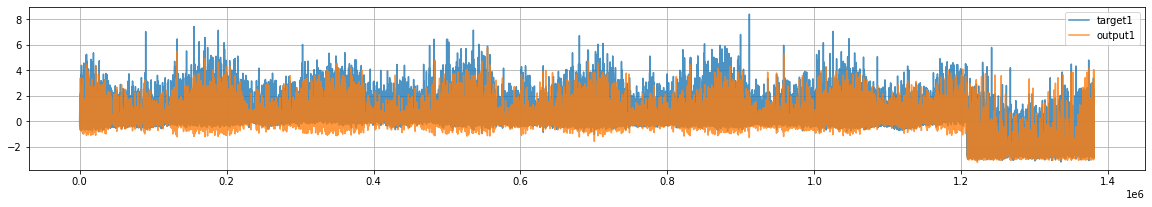

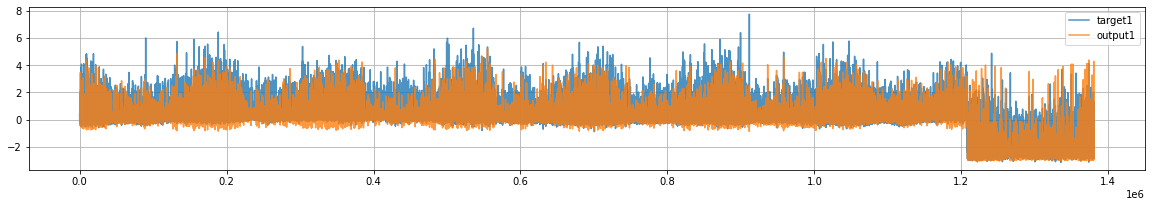

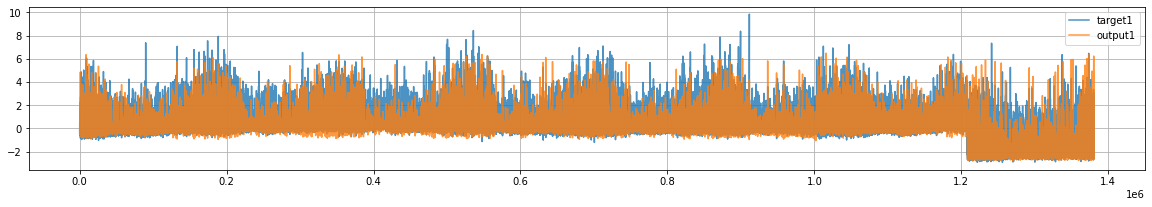

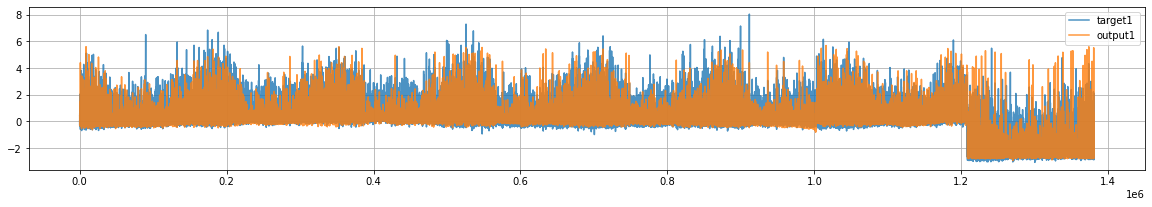

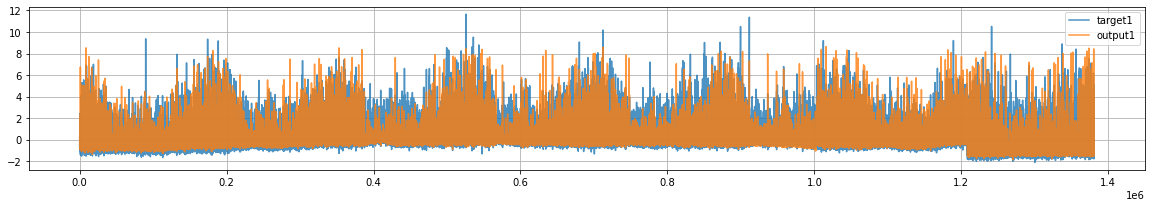

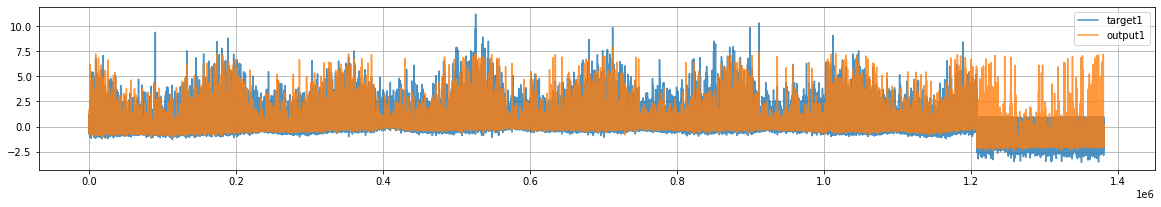

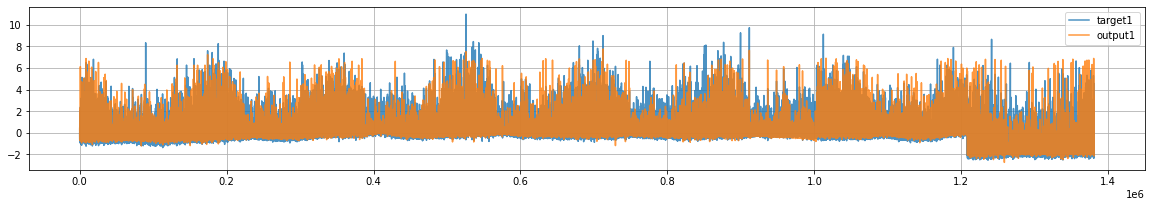

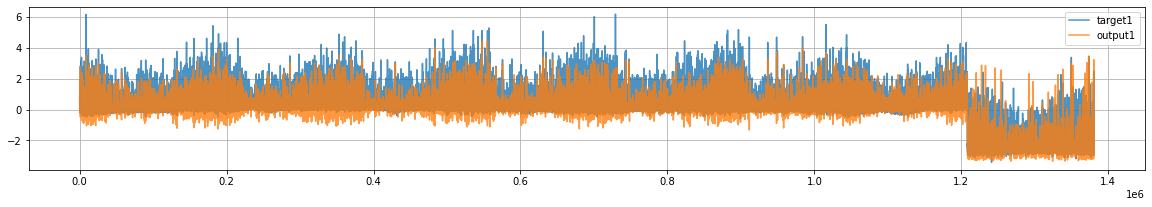

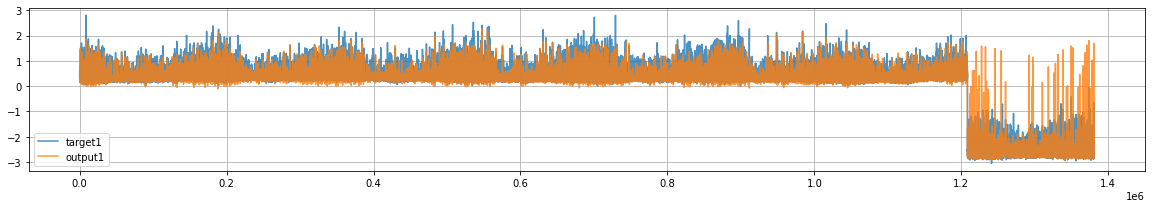

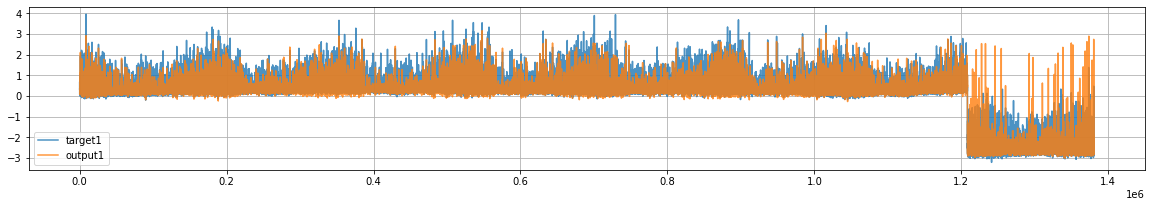

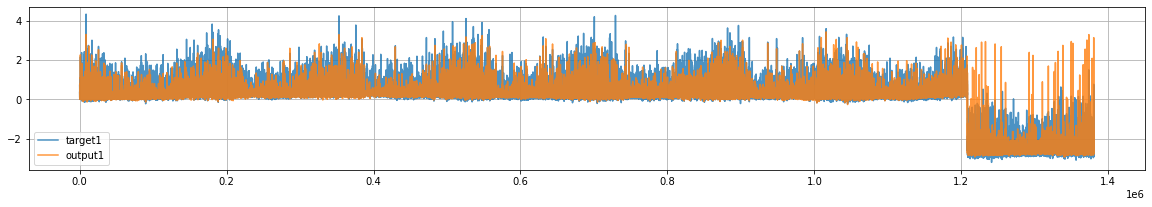

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


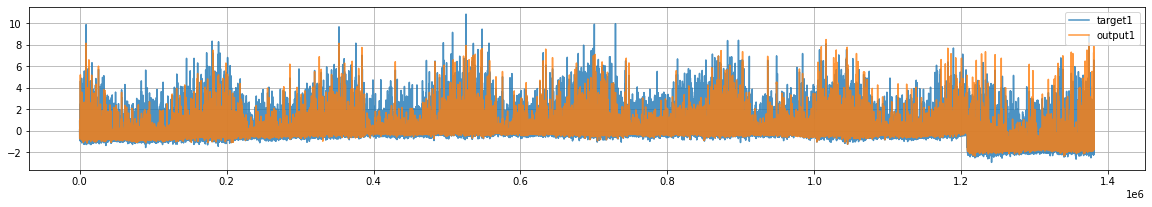

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


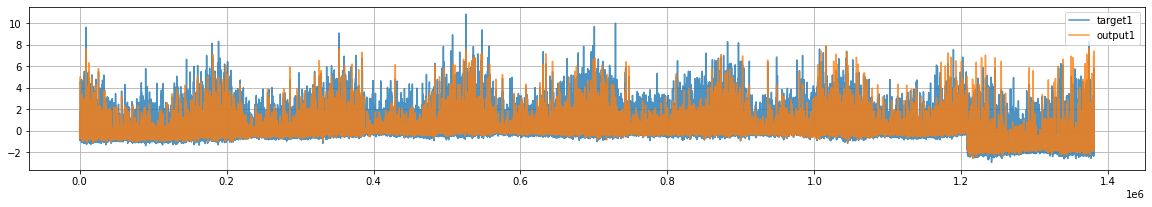

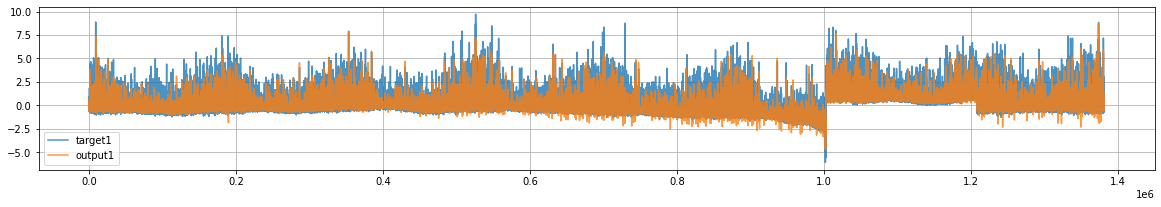

In [ ]:
#trainings set results
for i in range(14):
    fig=plt.figure(figsize=(20,3))
    plt.plot(x_train[:,i],label='target1',alpha=0.8)
    plt.plot(output0[:,i],label='output1',alpha=0.8)
    plt.grid()
    plt.legend()
    #plt.savefig('images/results/'+str(i)+'.png',bbox_inces='tight', pad_inches=0)
    plt.show()

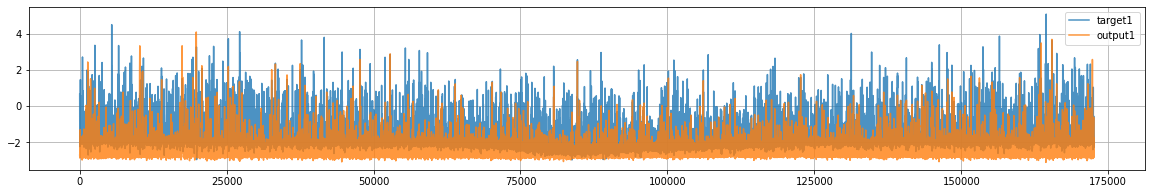

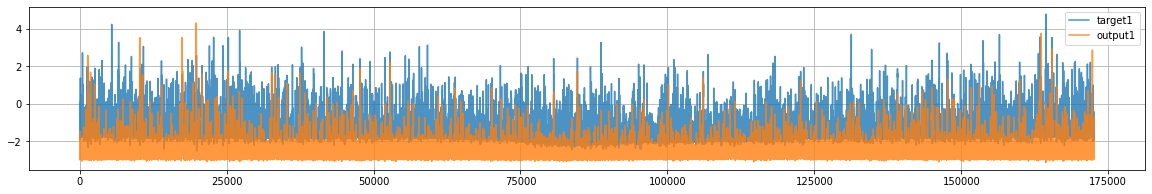

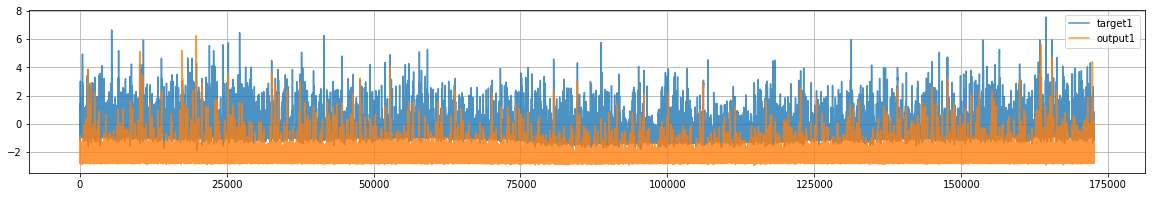

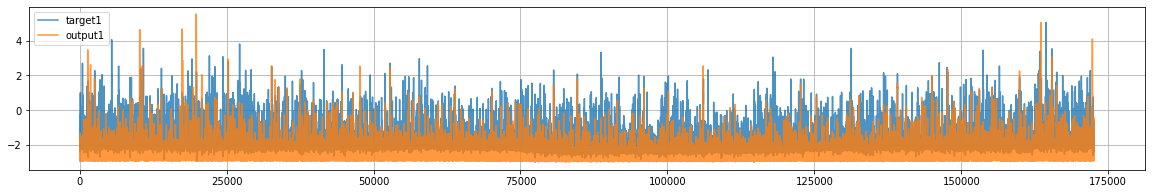

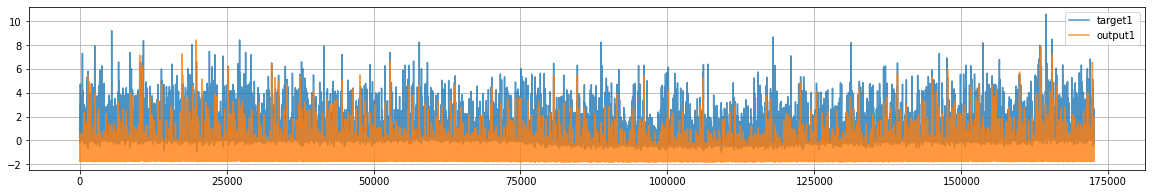

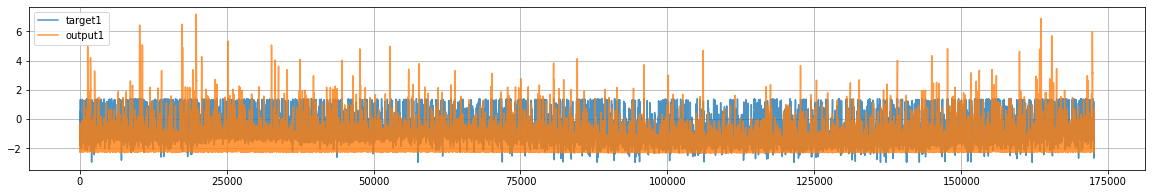

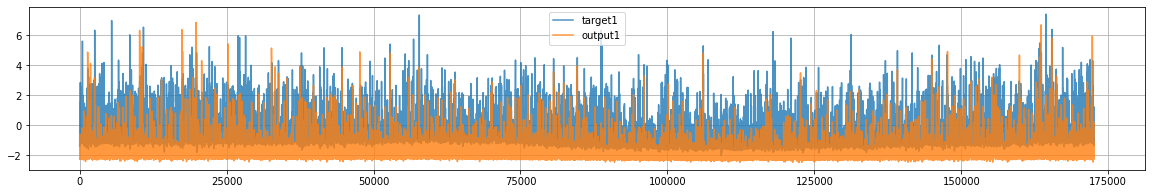

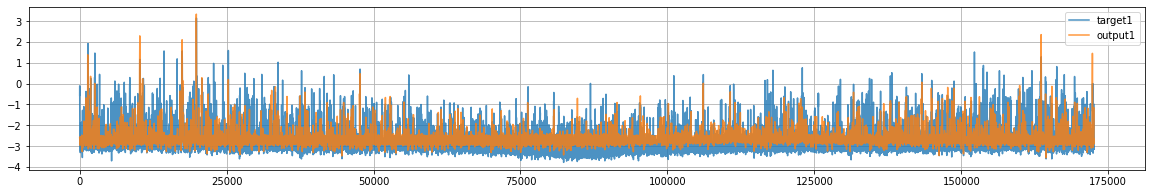

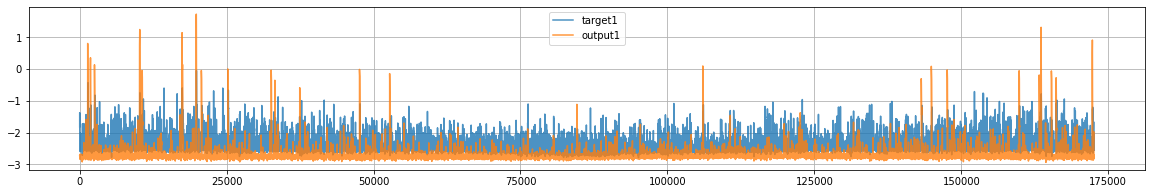

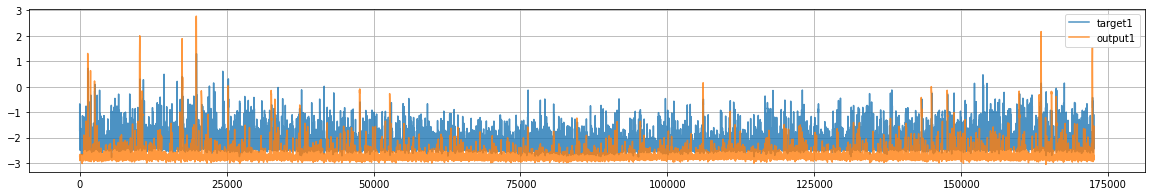

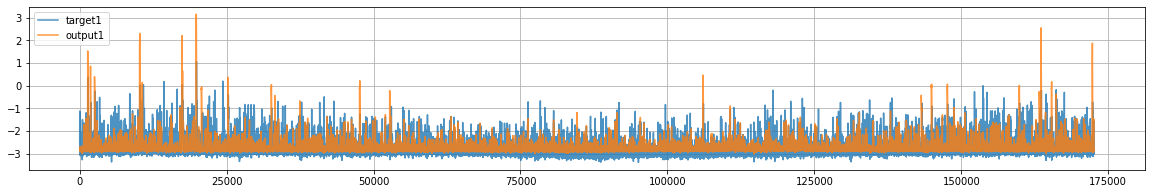

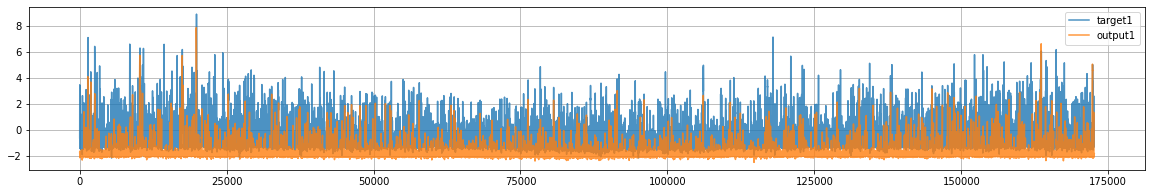

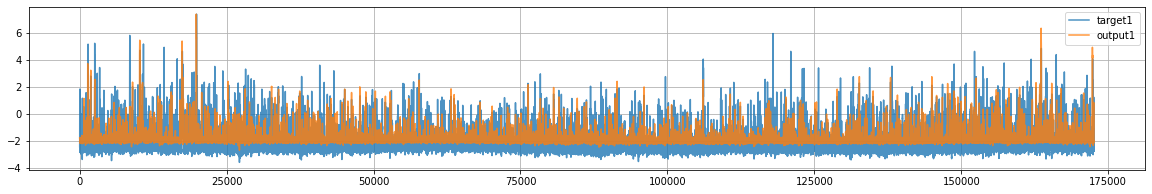

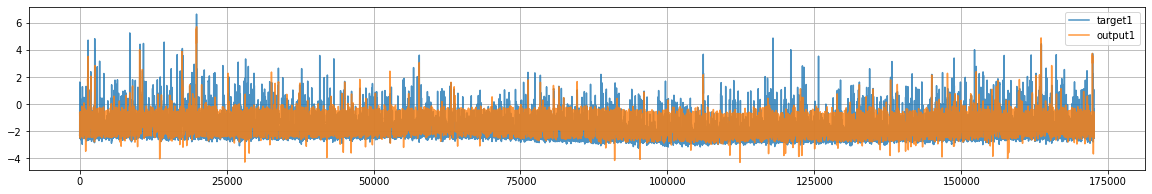

In [ ]:
#validation set resuslts
for i in range(14):
    fig=plt.figure(figsize=(20,3))
    plt.plot(x_test1[:,i],label='target1',alpha=0.8)
    plt.plot(output1[:,i],label='output1',alpha=0.8)
    plt.grid()
    plt.legend()
    #plt.savefig('images/results/val/'+str(i)+'.png',bbox_inces='tight', pad_inches=0)
    plt.show()

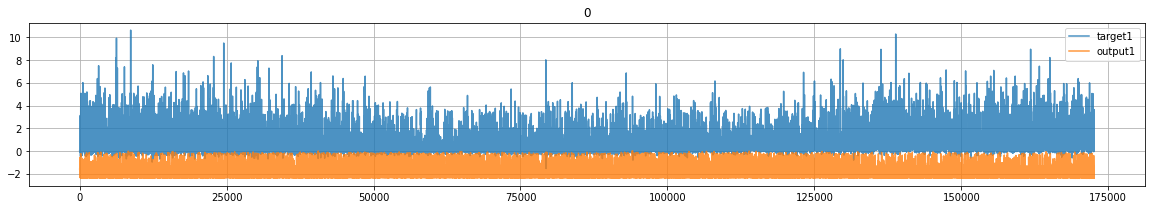

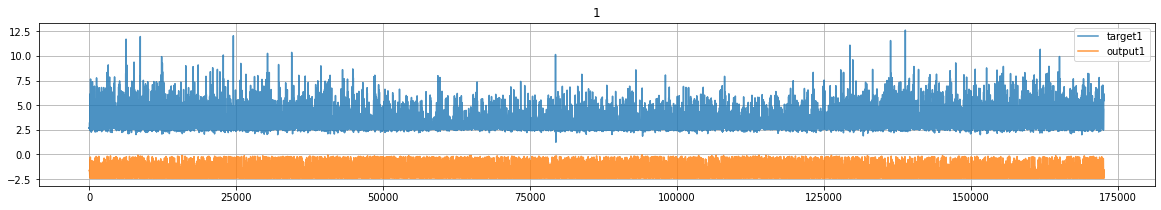

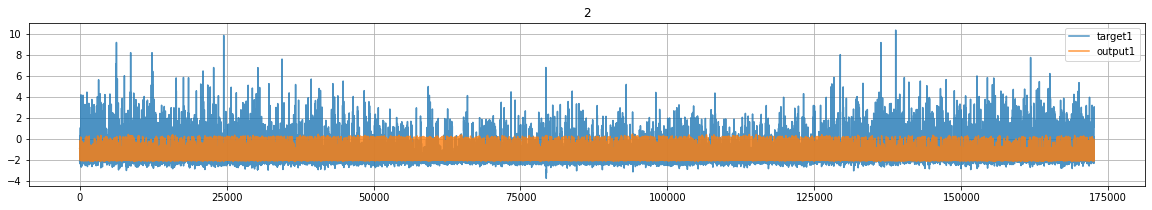

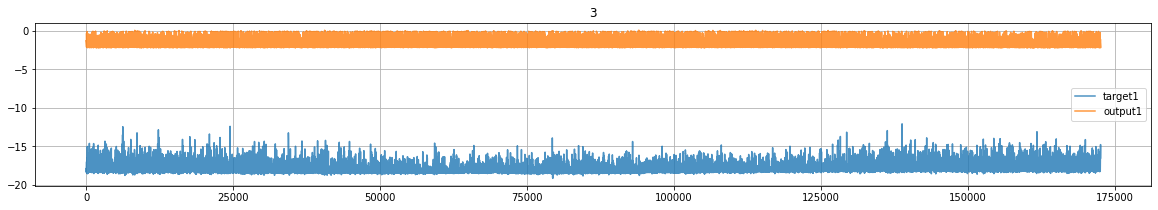

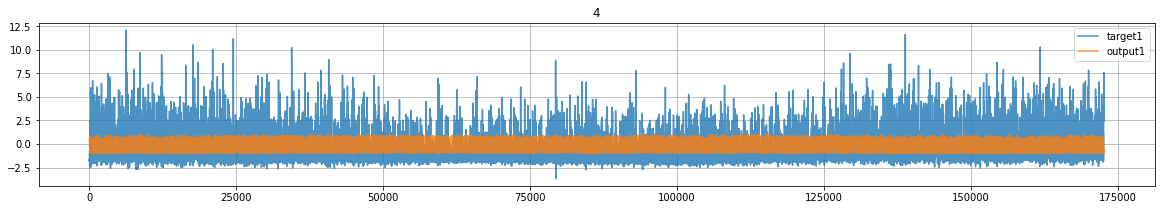

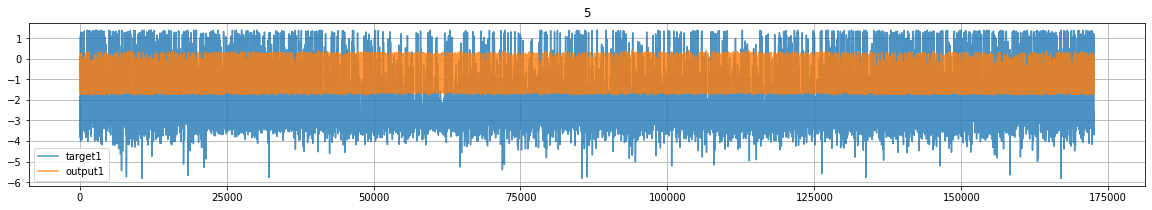

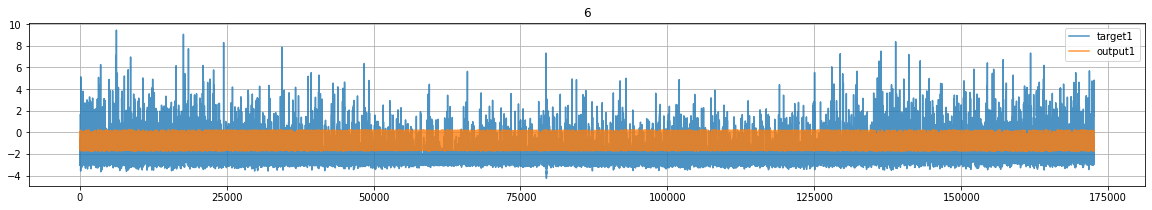

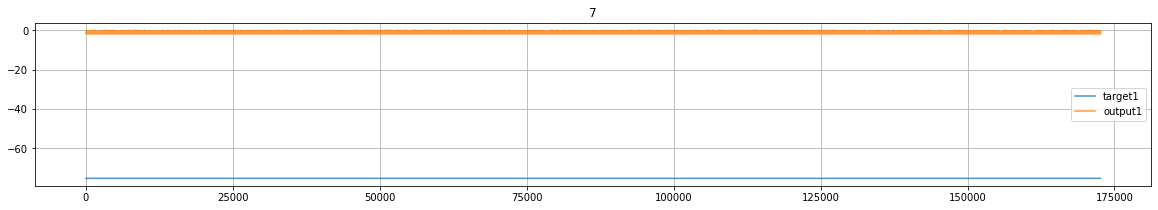

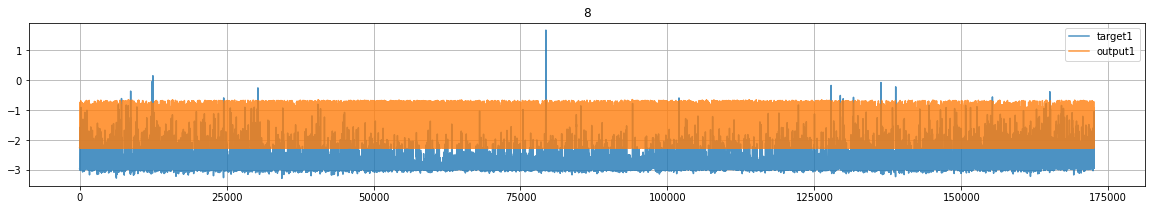

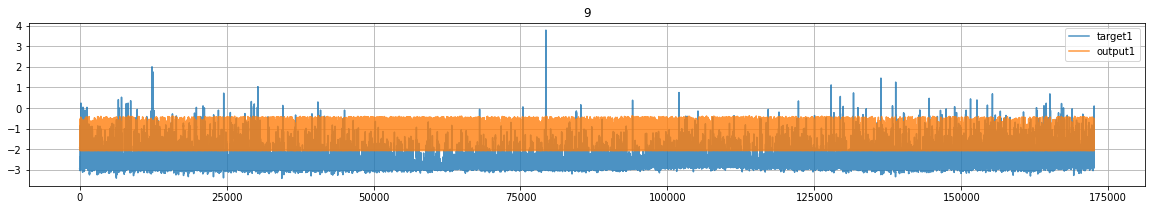

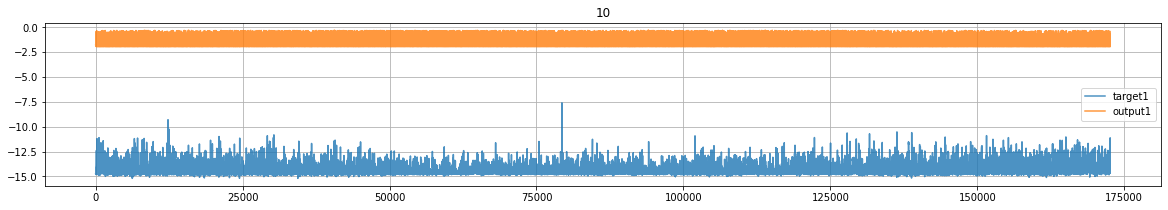

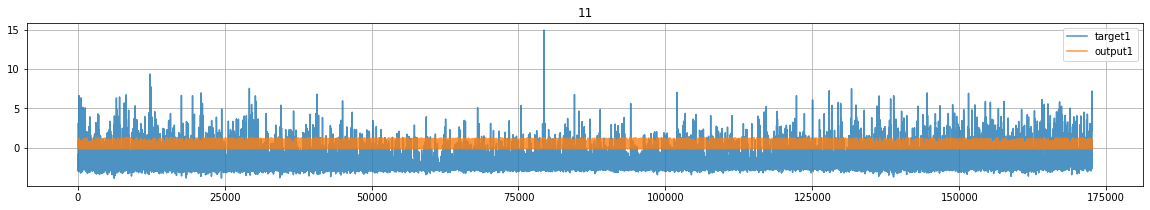

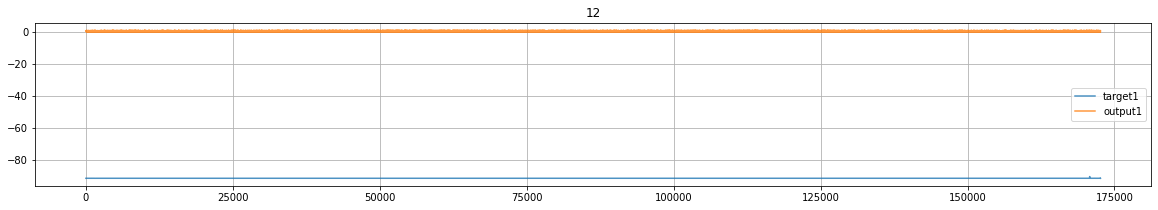

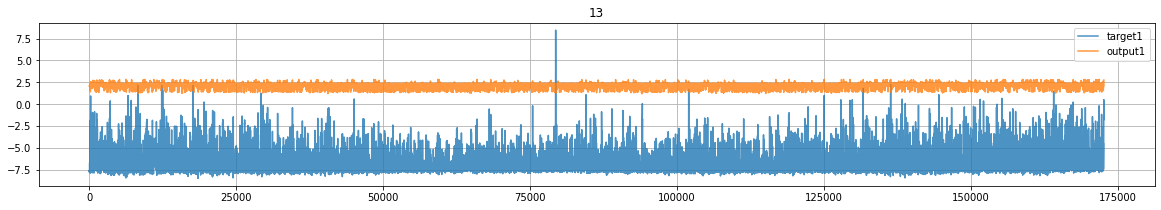

In [ ]:
#test set results
for i in range(14):
    fig=plt.figure(figsize=(20,3))
    plt.plot(x_test2[:,i],label='target1',alpha=0.8)
    plt.plot(output2[:,i],label='output1',alpha=0.8)
    plt.grid()
    plt.legend()
    #plt.savefig('images/results/test/'+str(i)+'.png',bbox_inces='tight', pad_inches=0)
    plt.title(str(i))
    plt.show()

In [ ]:
#test set resutls - MAPE
y_t=(x_test2*std_train)+m_train
y_p=(output2*std_train)+m_train
for i in range(14):
    mape=np.mean(np.abs((y_t[:,i]-y_p[:,i])/y_t[:,i]))*100
    print(i,mape)

0 2.2908908325891244
1 5.3912206741885615
2 0.8641051550707969
3 20.082838985977894
4 1.1358085660766564
5 1.010614990714908
6 0.9063190309488809
7 3144.3538956819184
8 2.0784367779340944
9 0.7655033377909037
10 30.06224418945026
11 1.6872086965619024
12 167.00394810904845
13 7.084848779024588
